# Minimum code for Extended Data Figure 4 qPCR panel

In [1]:
options(warn = -1)
suppressPackageStartupMessages({
  library(tidyverse)
  library(rasilabRtemplates)
})

In [2]:
if (!file.exists('../figures')){
    dir.create('../figures')
}
    

## Read in annotations

In [8]:
annotations <- read_csv("../annotations/sampleannotations.csv") %>% 
  print()

Rows: 48 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Well, Amplicon, Treatment, Reporter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 48 × 4
   Well  Amplicon Treatment Reporter
   <chr> <chr>    <chr>     <chr>   
 1 B02   globin   eFT226    PTC     
 2 B03   globin   4E1RCat   PTC     
 3 B04   globin   SMG1i     PTC     
 4 B05   globin   DMSO      PTC     
 5 B06   globin   eFT226    NTC     
 6 B07   globin   4E1RCat   NTC     
 7 B08   globin   SMG1i     NTC     
 8 B09   globin   DMSO      NTC     
 9 C02   globin   eFT226    PTC     
10 C03   globin   4E1RCat   PTC     
# … with 38 more rows


## Read in Ct data; join with annotations

In [9]:
cq_data <- read_csv("../../../../data/qpcr/nmd_reporter_validation/cq_values.csv") %>%
   select(Cq, Well) %>%
   rename(CT = Cq) %>%
   inner_join(annotations) %>%
   select(CT, Amplicon, Treatment, Reporter) %>%
   mutate(Treatment = fct_relevel(Treatment, "DMSO")) %>%
   print()

New names:
• `` -> `...1`
Rows: 60 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Well, Fluor, Content
dbl (8): Cq, Cq Mean, Cq Std. Dev, Starting Quantity (SQ), Log Starting Quan...
lgl (5): ...1, Target, Sample, Biological Set Name, Well Note

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = "Well"


# A tibble: 48 × 4
      CT Amplicon Treatment Reporter
   <dbl> <chr>    <fct>     <chr>   
 1  24.0 globin   eFT226    PTC     
 2  24.6 globin   4E1RCat   PTC     
 3  22.7 globin   SMG1i     PTC     
 4  26.2 globin   DMSO      PTC     
 5  21.6 globin   eFT226    NTC     
 6  20.3 globin   4E1RCat   NTC     
 7  20.9 globin   SMG1i     NTC     
 8  20.1 globin   DMSO      NTC     
 9  24.0 globin   eFT226    PTC     
10  24.3 globin   4E1RCat   PTC     
# … with 38 more rows


## Normalize β-globin expression to mCherry

In [12]:
norm_ct_inverted <- cq_data  %>%
  filter(!is.na(CT)) %>%
  group_by(Amplicon, Treatment, Reporter) %>%
  summarize(std_error = sd(CT),
            n = n(),
            CT = mean(CT)) %>%
  ungroup() %>%
  group_by(Treatment, Reporter) %>%
  mutate(norm_ct = CT - CT[Amplicon == "mCherry"],
         norm_error = sqrt(std_error^2 + std_error[Amplicon == "mCherry"]^2)) %>%
  filter(Amplicon == "globin") %>%
  mutate(norm_ct = -5 - norm_ct) %>%
  write_csv("../../../../source_data/figure_s4a.csv") %>%
  print()

`summarise()` has grouped output by 'Amplicon', 'Treatment'. You can override
using the `.groups` argument.


# A tibble: 8 × 8
# Groups:   Treatment, Reporter [8]
  Amplicon Treatment Reporter std_error     n    CT norm_ct norm_error
  <chr>    <fct>     <chr>        <dbl> <int> <dbl>   <dbl>      <dbl>
1 globin   DMSO      NTC         0.246      3  20.4  -0.366      0.457
2 globin   DMSO      PTC         0.0901     3  26.3  -4.80       0.294
3 globin   4E1RCat   NTC         0.0638     3  20.3  -0.109      0.302
4 globin   4E1RCat   PTC         0.178      3  24.4  -3.19       0.208
5 globin   eFT226    NTC         0.119      3  21.6  -0.395      0.347
6 globin   eFT226    PTC         0.0256     3  24.0  -2.37       0.145
7 globin   SMG1i     NTC         0.117      3  21.0  -0.984      0.528
8 globin   SMG1i     PTC         0.0609     3  22.6  -1.26       0.148


## Plot normalized β-globin reporter expression

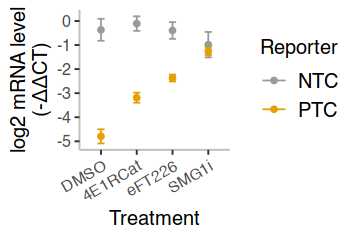

In [11]:
options(repr.plot.width=3, repr.plot.height=2)

norm_ct_inverted %>% 
  ggplot(aes(x = Treatment, y = norm_ct, ymax = norm_ct + norm_error, ymin = norm_ct - norm_error, color = Reporter)) +
  geom_point() +
  geom_errorbar(width = 0.2) +
  ylab("log2 mRNA level\n(-ΔΔCT)") +
  theme(axis.text.x = element_text(),
        axis.line = element_line(color = "grey")) +
  scale_x_discrete(guide = guide_axis(angle = 30)) +
  scale_color_manual(values = cbPalette) 

ggsave("../figures/mcherry_normalized_ct_values_inverted.pdf", height = 2, width = 3) 